# Emotion & Tone Detection in Speech

## Project Overview
This notebook extends our diarization work by analyzing **how** things are said, not just **what** is said and **who** said it.

It'll detect:
- **Emotions**: Angry, happy, sad, neutral, fearful, disgusted, surprised
- **Tone features**: Pitch, energy, speaking rate
- **Per-speaker patterns**: Does the interviewer sound hostile? Is the guest defensive?

## Why This Matters for Bias Detection
- **Hostile questioning** = aggressive tone, interruptions
- **Softball interviews** = friendly tone, no challenging
- **Emotional manipulation** = fear-mongering, outrage
- **Defensive responses** = indicators of difficult topics

## Technologies We'll Use
- **librosa**: Audio feature extraction (pitch, energy, tempo)
- **speechbrain**: Pre-trained emotion recognition models
- **Our diarization data**: To tie emotions to specific speakers

In [6]:
# Install required packages (run once)
!pip install librosa speechbrain torchaudio


  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached audioread-3.1.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached numba-0.62.1-cp312-cp312-win_amd64.whl.metadata (2.9 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-1.0.0-cp312-abi3-win_amd64.whl.metadata (5.6 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached msgpack-1.1.2-cp312-cp312-win_amd64.whl.metadata (8.4 kB)
  Using cached llvmlite-0.45.1-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
Using cached librosa-0.11.0-py3-none-any.whl (260 kB)
Using cached audioread-3.1.0-py3-none-any.whl (23 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached msgpack-1.1.2-cp312-cp312-win_amd64.whl (72 kB)
Using cached numba-0.62.1-cp312-cp312-win_amd64.whl (2.7 MB)
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)
Using cached soxr-1.0.0-cp312-abi3-win_amd64.whl (172 kB)
Using cached llvmlite-0.45.1-cp312-cp312-win_amd64.whl (38.1 


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# Import libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from speechbrain.pretrained import EncoderClassifier
import torch

print("Libraries imported")

c:\Users\norak\SpeakSense\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\norak\SpeakSense\venv\Lib\site-packages\speechbrain\utils\torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()


Libraries imported


C:\Python312\Lib\inspect.py:1001: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):
C:\Users\norak\AppData\Local\Temp\ipykernel_34060\1295107337.py:6: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier


## Step One: Load Audio File

We'll start by loading our audio file and examining its properties.

**What we're checking:**
- Sample rate (how many samples per second)
- Duration (length of audio)
- Audio waveform shape

In [8]:
# Load audio file
audio_file = "../data/US_DebateAudio.wav"

print(f"Loading audio: {audio_file}")

# librosa.load() : loads audio and converts to mono (single channel)
# sr=None : keeps the original sample rate
audio, sample_rate = librosa.load(audio_file, sr=None)

# Calculate duration
duration = len(audio) / sample_rate

print(f"Audio loaded successfully")
print(f"  Sample rate: {sample_rate} Hz")
print(f"  Duration: {duration:.2f} seconds ({duration/60:.2f} minutes)")
print(f"  Audio shape: {audio.shape}")

Loading audio: ../data/US_DebateAudio.wav
Audio loaded successfully
  Sample rate: 44100 Hz
  Duration: 565.78 seconds (9.43 minutes)
  Audio shape: (24950784,)


## Step Two: Visualize Audio Waveform

Let's see what the audio looks like. The waveform shows amplitude (loudness) over time.

**What to look for:**
- Peaks = loud moments (shouting, emphasis)
- Flat sections = silence or pauses
- Pattern changes = different speakers or emotions

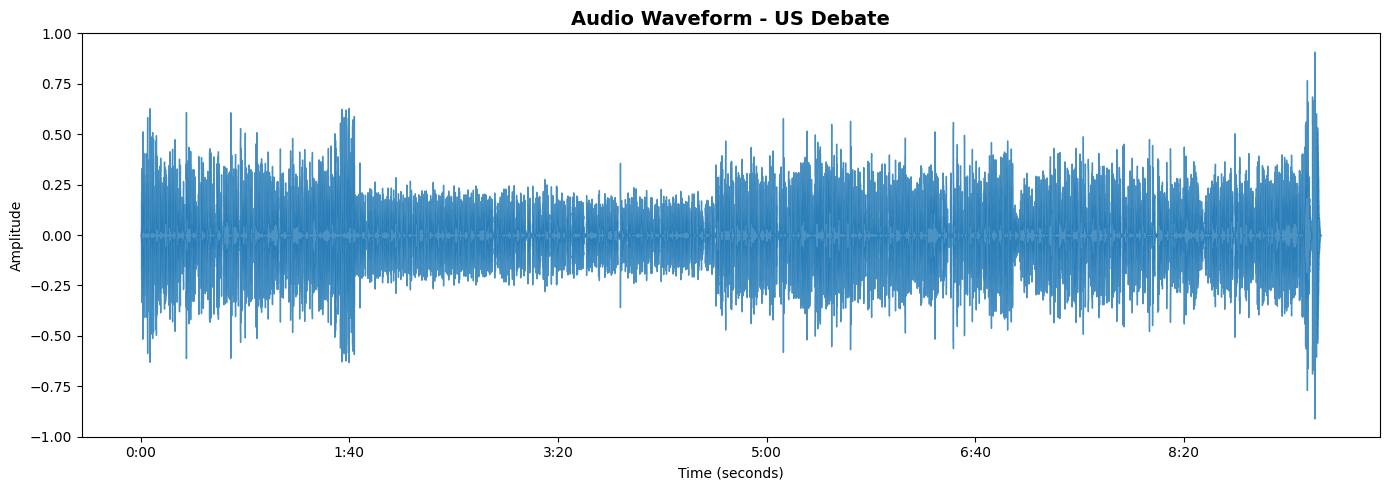

Waveform plotted successfully


In [9]:
# Create a waveform visualization
plt.figure(figsize=(14, 5))

# Plot the waveform
librosa.display.waveshow(audio, sr=sample_rate, alpha=0.8)

plt.title('Audio Waveform - US Debate', fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

print("Waveform plotted successfully")